Script to dowload other data:
- terrain: DEM
- features: aerialways (teleferica, impianti a fune..)
- hiking trails

In [1]:
import requests
import geopandas as gpd
import os
import zipfile
import shapely
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import overpass
from owslib.wcs import WebCoverageService
from pyproj import Proj, transform
import rasterio
import rasterio.mask
import numpy as np

import warnings
warnings.simplefilter("ignore")

In [2]:
# Same as water_download.ipynb
def download_and_unzip_shapefile(url, extract_to='../data/', download=True):

    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    if download:
        # Download the file
        local_zip_file = os.path.join(extract_to, 'shapefile.zip')
        with requests.get(url, stream=True) as r:
            with open(local_zip_file, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    
    elif not download:
        local_zip_file = url
        
    # Extract the file
    with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    os.remove(local_zip_file)
    
    # Return the path to the directory containing the shapefiles
    return print(f'Shapefile ready in {extract_to}')

# Confini Provincia
Source: https://siat.provincia.tn.it/geonetwork/srv/ita/catalog.search#/metadata/p_TN:377793f1-1094-4e81-810e-403897418b23

Will be used to clip other datasets.

In [3]:
provincia_url = 'https://siatservices.provincia.tn.it/idt/vector/p_TN_377793f1-1094-4e81-810e-403897418b23.zip'
download_and_unzip_shapefile(provincia_url, extract_to='../data/clip/')

Shapefile ready in ../data/clip/


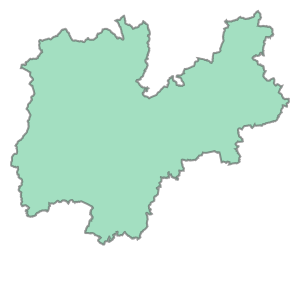

In [16]:
provincia = gpd.read_file('../data/clip/ammprv_v.shp')
provincia.geometry[0]

In [7]:
provincia.crs

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Terrain Data
Source: https://tinitaly.pi.ingv.it/wcs_service.html (original res: 10x10m)
- DEM
- Hillshade
- Slope

Functions

In [41]:
# Function to perform request 
def tinitaly_request(
    bbox_utm:list,
    width:int,
    height:int,
    coverage_id='TINItaly_1_1:tinitaly_dem',
    destination = '../data/terrain/',
    crs = 'EPSG:32632'):

    wcs_url = 'http://tinitaly.pi.ingv.it/TINItaly_1_1/wcs'
    # coverage_id = 'TINItaly_1_1:tinitaly_dem'
    # crs = 'EPSG:32632'
    #destination = '../data/terrain/'

    params = {
        'service': 'WCS',
        'request': 'GetCoverage',
        'version': '1.0.0',
        'coverage': coverage_id,
        'bbox': ','.join(map(str, bbox_utm)),
        'crs': crs,
        'format': 'GeoTIFF',
        'width': width,
        'height': height
    }

    response = requests.get(wcs_url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the response content to a file
        if not os.path.exists(destination):
            os.makedirs(destination)
        output_file = destination + coverage_id.split(':')[-1] + '.tif'
        with open(output_file, 'wb') as file:
            file.write(response.content)
        print(f"Coverage saved to {output_file}")
        return output_file
    else:
        print(f"Error: {response.status_code}")

In [42]:
# Function to clip the raster on provincia
def clip_raster(
    raster_path, 
    prov_path='../data/clip/ammprv_v.shp',
    destination='../data/terrain/'):

    with rasterio.open(raster_path) as src:
        dem_data = src.read(1)  # Read the first band
        dem_transform = src.transform  # Get the transform
        dem_crs = src.crs  # Get the CRS
        dem_nodata = src.nodata

    # Read the polygon
    provincia = gpd.read_file(prov_path)
    polygon = provincia['geometry'][0]   

    # Convert polygon to GeoJSON-like mapping
    polygon_geom = [mapping(polygon)]

    # Mask the DEM with the polygon
    with rasterio.open(raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, polygon_geom, crop=True)
        out_meta = src.meta.copy()

    # Update the metadata to reflect the new dimensions and transform
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": dem_nodata
    })

    # Save the clipped DEM
    file_name = 'clipped_' + os.path.basename(raster_path).split('_')[-1]
    with rasterio.open(destination + file_name, "w", **out_meta) as dest:
        dest.write(out_image)

    print(f"Raster clipped successfully and saved at {destination + file_name}")

    return destination + file_name

In [50]:
# Function to plot the clipped raster
def plot_clipped_raster(raster_path):
    with rasterio.open(raster_path) as src:
        # Read the first band of the dataset
        dem_data = src.read(1)
        dem_nodata = src.nodata

    # Create a masked array for plotting
    clipped_dem_masked = np.ma.masked_equal(dem_data, dem_nodata)

    titles = {'dem': 'Digital Elevation Model (DEM)',
              'hshd': 'Hillshade',
              'slope': 'Slope'}

    labels = {'dem': 'Elevation [m]',
              'hshd': 'Brightness',
              'slope': 'Slope [degrees]'}
    obj = os.path.basename(raster_path).split('_')[-1].split('.')[0]

    plt.imshow(clipped_dem_masked, cmap='binary')
    plt.colorbar(label=labels[obj], shrink=0.75)
    plt.title(titles[obj])
    plt.show()

Preparation

In [38]:
## PARAMETERS: bounding box & resolution
bbox_4326 = (10.46750857, 45.69873184, 11.94937569, 46.53633029) # TRENTINO
# Desired resolution (meters)
desired_resolution = 50

# Define the source and destination CRS
src_crs = Proj(init='epsg:4326')  # WGS84 (deg)
dst_crs = Proj(init='epsg:32632')  # UTM zone 32N (meters)
# Transform the bounding box coordinates to UTM
xmin, ymin = transform(src_crs, dst_crs, bbox_4326[0], bbox_4326[1])
xmax, ymax = transform(src_crs, dst_crs, bbox_4326[2], bbox_4326[3])
bbox_utm = (xmin, ymin, xmax, ymax)

print(f"Transformed bounding box in UTM: {bbox_utm}")

# Calculate width and height in pixels
width = int((xmax - xmin) / desired_resolution)
height = int((ymax - ymin) / desired_resolution)
print(f"Width in pixels: {width}, Height in pixels: {height}")

Transformed bounding box in UTM: (614247.4307366736, 5061622.641956749, 726155.1390219606, 5157866.9110916145)
Width in pixels: 2238, Height in pixels: 1924


In [40]:
# URL of the WCS service capabilities
wcs_getCapabilities_url = 'http://tinitaly.pi.ingv.it/TINItaly_1_1/wcs?service=WCS&request=getCapabilities'
# Connect to the WCS
wcs = WebCoverageService(wcs_getCapabilities_url, version='1.0.0')
wcs.contents

{'TINItaly_1_1:tinitaly_dem': <owslib.coverage.wcs100.ContentMetadata at 0x1233d4ee0>,
 'TINItaly_1_1:tinitaly_hsv': <owslib.coverage.wcs100.ContentMetadata at 0x1233d6e60>,
 'TINItaly_1_1:tinitaly_hshd': <owslib.coverage.wcs100.ContentMetadata at 0x1233d4cd0>,
 'TINItaly_1_1:tinitaly_od': <owslib.coverage.wcs100.ContentMetadata at 0x1233d4fa0>,
 'TINItaly_1_1:tinitaly_svf_2d5': <owslib.coverage.wcs100.ContentMetadata at 0x1233d44f0>,
 'TINItaly_1_1:tinitaly_svf_ea': <owslib.coverage.wcs100.ContentMetadata at 0x1233d4400>,
 'TINItaly_1_1:tinitaly_slope': <owslib.coverage.wcs100.ContentMetadata at 0x1233d6e30>,
 'TINItaly_1_1:tinitaly_slope_2d5': <owslib.coverage.wcs100.ContentMetadata at 0x1233d4eb0>}

## DEM

Coverage saved to ../data/terrain/tinitaly_dem.tif
Raster clipped successfully and saved at ../data/terrain/clipped_dem.tif


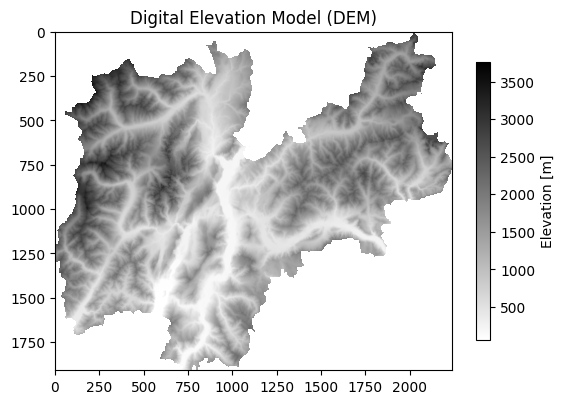

In [51]:
dem_path = tinitaly_request(bbox_utm, width, height)
dem_clip_path = clip_raster(raster_path=dem_path)
plot_clipped_raster(dem_clip_path)

## Hillshade

Coverage saved to ../data/terrain/tinitaly_hshd.tif
Raster clipped successfully and saved at ../data/terrain/clipped_hshd.tif


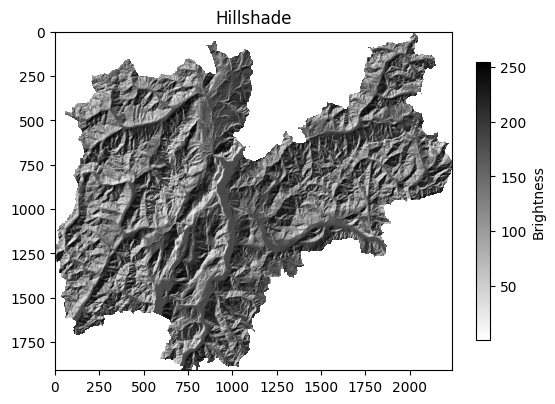

In [52]:
hshd_path = tinitaly_request(bbox_utm, width, height, coverage_id='TINItaly_1_1:tinitaly_hshd')
hshd_clip_path = clip_raster(raster_path=hshd_path)
plot_clipped_raster(hshd_clip_path)

## Slope

Coverage saved to ../data/terrain/tinitaly_slope.tif
Raster clipped successfully and saved at ../data/terrain/clipped_slope.tif


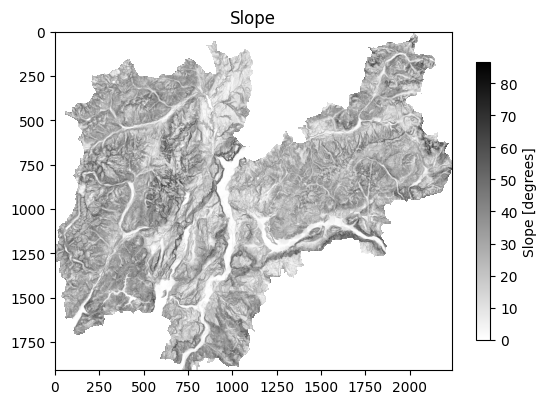

In [53]:
slope_path = tinitaly_request(bbox_utm, width, height, coverage_id='TINItaly_1_1:tinitaly_slope')
slope_clip_path = clip_raster(raster_path=slope_path)
plot_clipped_raster(slope_clip_path)

# Hiking trails
Source: SIAT 'tracciati alpini' https://siat.provincia.tn.it/geonetwork/srv/ita/catalog.search#/metadata/p_TN:f3547bc8-bf1e-4731-85d2-2084d1f4ba07

In [25]:
# access point
sentieri_url = 'https://siatservices.provincia.tn.it/idt/vector/p_TN_f3547bc8-bf1e-4731-85d2-2084d1f4ba07.zip'
download_and_unzip_shapefile(sentieri_url, extract_to='../data/trails/')

# Rename files to remove spaces
for root, dirs, files in os.walk('../data/trails/'):
    for file in files:
        if ' ' in file:
            new_file_name = file.replace(' ', '_')
            os.rename(os.path.join(root, file), os.path.join(root, new_file_name))

Shapefile ready in ../data/trails/


In [26]:
trails_gdf = gpd.read_file('../data/trails/Sentieri_della_SAT.shp')
trails_gdf.head(5)

,numero,classid,dataagg,gr_mont,datafine,loc_fine,objectid,t_andata,denominaz,quota_max,...,t_ritorno,competenza,comuni_toc,difficolta,loc_inizio,lun_inclin,lun_planim,quota_fine,quota_iniz,geometry
0,E106,tur006_E106,2021/01/01 00:00:00.000,MONTI LESSINI,None,MALGA LAVACCHIONE,31538,03:45:00.000,None,1408,...,02:45:00.000,SEZ. SAT ALA,ALA,E,VAL FREDDA,6710,6510,1402,301,"LINESTRING (653619.72 5066118.31, 653633.57 50..."
1,E176,tur006_E176,2021/01/01 00:00:00.000,CAREGA - PICCOLE DOLOMITI,None,PASSO DEGLI ONARI - bivio 149-CAI,31539,00:40:00.000,VF - EEA-F,1761,...,00:30:00.000,SEZ. SAT VALLARSA,VALLARSA,EEA-F,pr: SELLETTA NO,1160,900,1759,1586,"LINESTRING (668794.25 5068464.05, 668794.03 50..."
2,E101,tur006_E101,2021/01/01 00:00:00.000,PASUBIO - COLSANTO,None,"RIFUGIO ""VINCENZO LANCIA""",31540,02:40:00.000,None,1800,...,02:00:00.000,"SEZ. SAT ROVERETO, RIF. ALPE POZZA ""VINCENZO L...",TRAMBILENO,E,GIAZZERA,6470,6420,1800,1092,"LINESTRING (662888.22 5080025.22, 662893.92 50..."
3,E105B,tur006_E105B,2021/01/01 00:00:00.000,PASUBIO - COLSANTO,None,SELLETTA DEL GROVIGLIO,31541,00:10:00.000,None,2127,...,00:10:00.000,"RIF. ALPE POZZA ""VINCENZO LANCIA""",TRAMBILENO,E,SELLA AL PICCOLO ROITE,220,210,2082,2127,"LINESTRING (669203.29 5074070.41, 669213.78 50..."
4,E103,tur006_E103,2021/01/01 00:00:00.000,FINONCHIO - MONTE MAGGIO,None,ZOM - Pr� del Finonchio,31542,02:00:00.000,None,1576,...,01:30:00.000,SEZ. SAT ROVERETO,ROVERETO,E,MOIETTO,4020,3940,1576,923,"LINESTRING (661850.95 5084590.91, 661865.34 50..."


In [ ]:
trails_gdf.columns

In [ ]:
trails_gdf.difficolta.unique()

Difficoltà:
- E: Escursionistico
- EE: Escursionisti Esperti
- EEA-D: Escursionisti Esperti con Attrezzatura alpinistica - Difficile
- EEA-F: Escursionisti Esperti con Attrezzatura alpinistica - Facile
- EEA-MD: Escursionisti Esperti con Attrezzatura alpinistica - Molto Difficile
- EEA-PD: Escursionisti Esperti con Attrezzatura alpinistica - Poco Difficile
- T: Turistico

(https://www.sat.tn.it/sentieri/scala-difficolta/)

<Axes: >

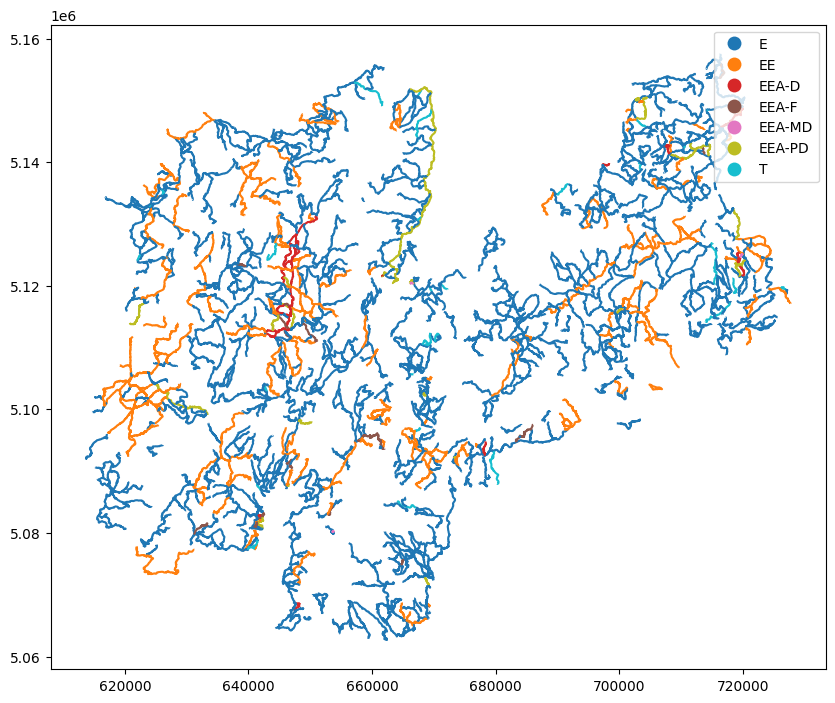

In [28]:
trails_gdf.plot(column='difficolta', legend=True, figsize=(10, 10))

In [ ]:
#TODO check crs !!!!